In [75]:
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer

In [147]:
df = pd.read_csv("csvs/df_nosubj.csv")
df = df.rename(columns={'Dependency': 'Holistic\nRecollection',
                        'PCAccuracy':'Relational\nBinding',
                        'Target':'Mnemonic\ndiscrimination\n(Target)',
                        'MausQs':'Probed\nQuestion\nAccuracy',
                        'MausFR':'Free\nRecall\nAccuracy',
                        'AM':'Autobiographical\nMemory',
                        'Foil':'Mnemonic\ndiscrimination\n(Foil)',
                        'Lure':'Mnemonic\ndiscrimination\n(Lure)',
                        'KBit_Score': 'Standard\nKBIT'})
df_norm=(df-df.mean())/df.std()
# re-order columns: (and eliminate age and gender)
df_norm = df_norm[['Relational\nBinding','LocAniLink','AniObjLink',
                   'AniLocLink','ObjAniLink','LocObjLink',
                   'ObjLocLink','Mnemonic\ndiscrimination\n(Target)',
                   'PSObjTarget','PSLocTarget','PSAniTarget',
                   'Probed\nQuestion\nAccuracy',
                   'Free\nRecall\nAccuracy','Autobiographical\nMemory',
                   'AM_parent','AM_exp',
                   'Raw KBIT','Standard\nKBIT','Holistic\nRecollection',
                   'Mnemonic\ndiscrimination\n(Foil)',
                   'PSObjFoil','PSLocFoil','PSAniFoil',
                   'Mnemonic\ndiscrimination\n(Lure)',
                   'PSObjLure','PSLocLure','PSAniLure']] 
df_norm = df_norm[['Relational\nBinding','Mnemonic\ndiscrimination\n(Target)',
                   'Probed\nQuestion\nAccuracy',
                   'Free\nRecall\nAccuracy','Autobiographical\nMemory',
                   'Holistic\nRecollection',
                   'Mnemonic\ndiscrimination\n(Foil)',
                   'Mnemonic\ndiscrimination\n(Lure)']] 


### Does memory improve with age?

In [148]:
cols_ = list(df_norm.columns)
d = []
for col in cols_:
    d.append(pg.corr(df['Age (months)'], df[col]).to_dict('index')['pearson'])
corrdf = pd.DataFrame(d)
corrdf.index = cols_
for k,v in {'PS/PC':['Relational\nBinding','Holistic\nRecollection',
            'Mnemonic\ndiscrimination\n(Target)',
            'Mnemonic\ndiscrimination\n(Foil)',
            'Mnemonic\ndiscrimination\n(Lure)'],
           'Maus/AM':['Probed\nQuestion\nAccuracy',
            'Free\nRecall\nAccuracy','Autobiographical\nMemory']}.items():
    print('Correrelations for: '+k)
    display(corrdf.loc[v])

Correrelations for: PS/PC


,n,r,CI95%,p-val,BF10,power
Relational\nBinding,76,0.445523,"[0.24, 0.61]",0.000055,417.395,0.984500
Holistic\nRecollection,76,-0.072220,"[-0.29, 0.16]",0.535272,0.173,0.095085
Mnemonic\ndiscrimination\n(Target),76,0.461758,"[0.26, 0.62]",0.000027,814.537,0.990167
Mnemonic\ndiscrimination\n(Foil),76,-0.445552,"[-0.61, -0.24]",0.000055,417.878,0.984512
Mnemonic\ndiscrimination\n(Lure),76,-0.392434,"[-0.57, -0.18]",0.000454,59.548,0.945597


Correrelations for: Maus/AM


,n,r,CI95%,p-val,BF10,power
Probed\nQuestion\nAccuracy,76,0.504507,"[0.31, 0.66]",3.369420e-06,5690.491,0.997536
Free\nRecall\nAccuracy,76,0.678805,"[0.54, 0.78]",1.596270e-11,6.674e+08,1.000000
Autobiographical\nMemory,76,0.306106,"[0.09, 0.5]",7.161896e-03,4.975,0.775675


In [138]:
# Compute the correlation matrix
corr_matrix = df_norm.corr()
# threshold variables above 0.7 correlation:
threshlist = []
threshold = 0.7
for row in corr_matrix.index.values.tolist():
    cols = corr_matrix.columns[(corr_matrix.loc[row].gt(threshold))|(corr_matrix.loc[row].lt(-1*threshold))].tolist()
    for col in cols:
        if row != col:
            threshlist.append([row,col])
            print(row,col,corr_matrix.loc[row,col])

Relational/nBinding Mnemonic discrimination (Target) 0.877319354842637
Relational/nBinding Mnemonic discrimination (Foil) -0.8467271433224226
Relational/nBinding Mnemonic discrimination (Lure) -0.7451932017856813
Mnemonic discrimination (Target) Relational/nBinding 0.877319354842637
Mnemonic discrimination (Target) Mnemonic discrimination (Foil) -0.967052918123666
Mnemonic discrimination (Target) Mnemonic discrimination (Lure) -0.8453626886141826
Mnemonic discrimination (Foil) Relational/nBinding -0.8467271433224226
Mnemonic discrimination (Foil) Mnemonic discrimination (Target) -0.967052918123666
Mnemonic discrimination (Lure) Relational/nBinding -0.7451932017856813
Mnemonic discrimination (Lure) Mnemonic discrimination (Target) -0.8453626886141826


In [4]:
# Eliminate all 6 pairwise associations from PC task
# Eliminate all Target-related variables from PS task
# Eliminate all Foil-related variables from PS task
# Eliminate Lure and Obj-Lure and Ani-Lure
# Eliminate AM with Parent and experimenter
df_norm = df_norm.drop(  
['LocAniLink','AniObjLink','AniLocLink',
'ObjAniLink','LocObjLink','ObjLocLink',
'Target','PSAniTarget','PSObjTarget','PSLocTarget',
'Foil','PSObjFoil','PSLocFoil','PSAniFoil','Lure','PSObjLure','PSAniLure',
 'AM_parent','AM_exp'], axis=1)


In [119]:
# Find any weakly correlated variables:
corr_matrix = df_norm.corr()
threshlist = []
threshold = 0.2
for row in corr_matrix.index.values.tolist():
    tmp = corr_matrix.drop(index=[row])
    if (tmp[row].max()<threshold) & (tmp[row].min()>(-1*threshold)):
        threshlist.append(row)
        print(row)
# drop Dependency
#df_norm = df_norm.drop(['Dependency'], axis=1)

Holistic Recollection


In [159]:
def plot_xcorr(df):
    sns.set_theme(style="white",font_scale=1.2)
    corr_matrix = df.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    g = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1,center=0,
                square=True, linewidths=.5, 
                    cbar_kws={"shrink": .75,'label': 'Correlation',
                              'ticks':[-1,0,1]},
                    annot=True)
    g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 10)
    plt.xticks(rotation=0)

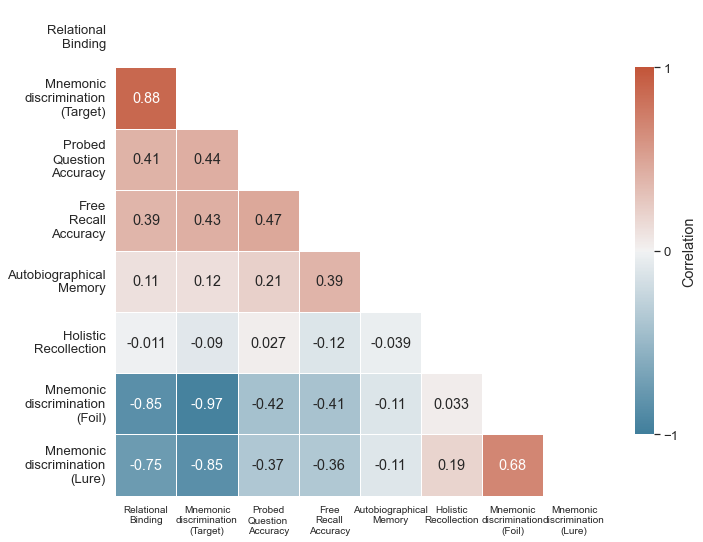

In [160]:
#df_norm = df_norm[['MausQs', 'MausFR', 'Raw KBIT','AM', 'Standard KBIT',
#           'PCAccuracy', 'PSLocLure']] 
plot_xcorr(df_norm)

In [162]:
from scipy import stats
for col in df_norm.columns:
    res = stats.normaltest(df_norm[col])
    print(col)
    print(res)
    

Relational
Binding
NormaltestResult(statistic=81.79690694839023, pvalue=1.729925250370204e-18)
Mnemonic
discrimination
(Target)
NormaltestResult(statistic=50.679888944683256, pvalue=9.885575194876748e-12)
Probed
Question
Accuracy
NormaltestResult(statistic=34.02025247313716, pvalue=4.0982272714117785e-08)
Free
Recall
Accuracy
NormaltestResult(statistic=1.6226315403856106, pvalue=0.4442731201510698)
Autobiographical
Memory
NormaltestResult(statistic=37.11008015746634, pvalue=8.742758504315956e-09)
Holistic
Recollection
NormaltestResult(statistic=12.267023521470922, pvalue=0.002168950734765303)
Mnemonic
discrimination
(Foil)
NormaltestResult(statistic=17.894077292965797, pvalue=0.00013012192707536428)
Mnemonic
discrimination
(Lure)
NormaltestResult(statistic=3.700393067872522, pvalue=0.15720626691089556)


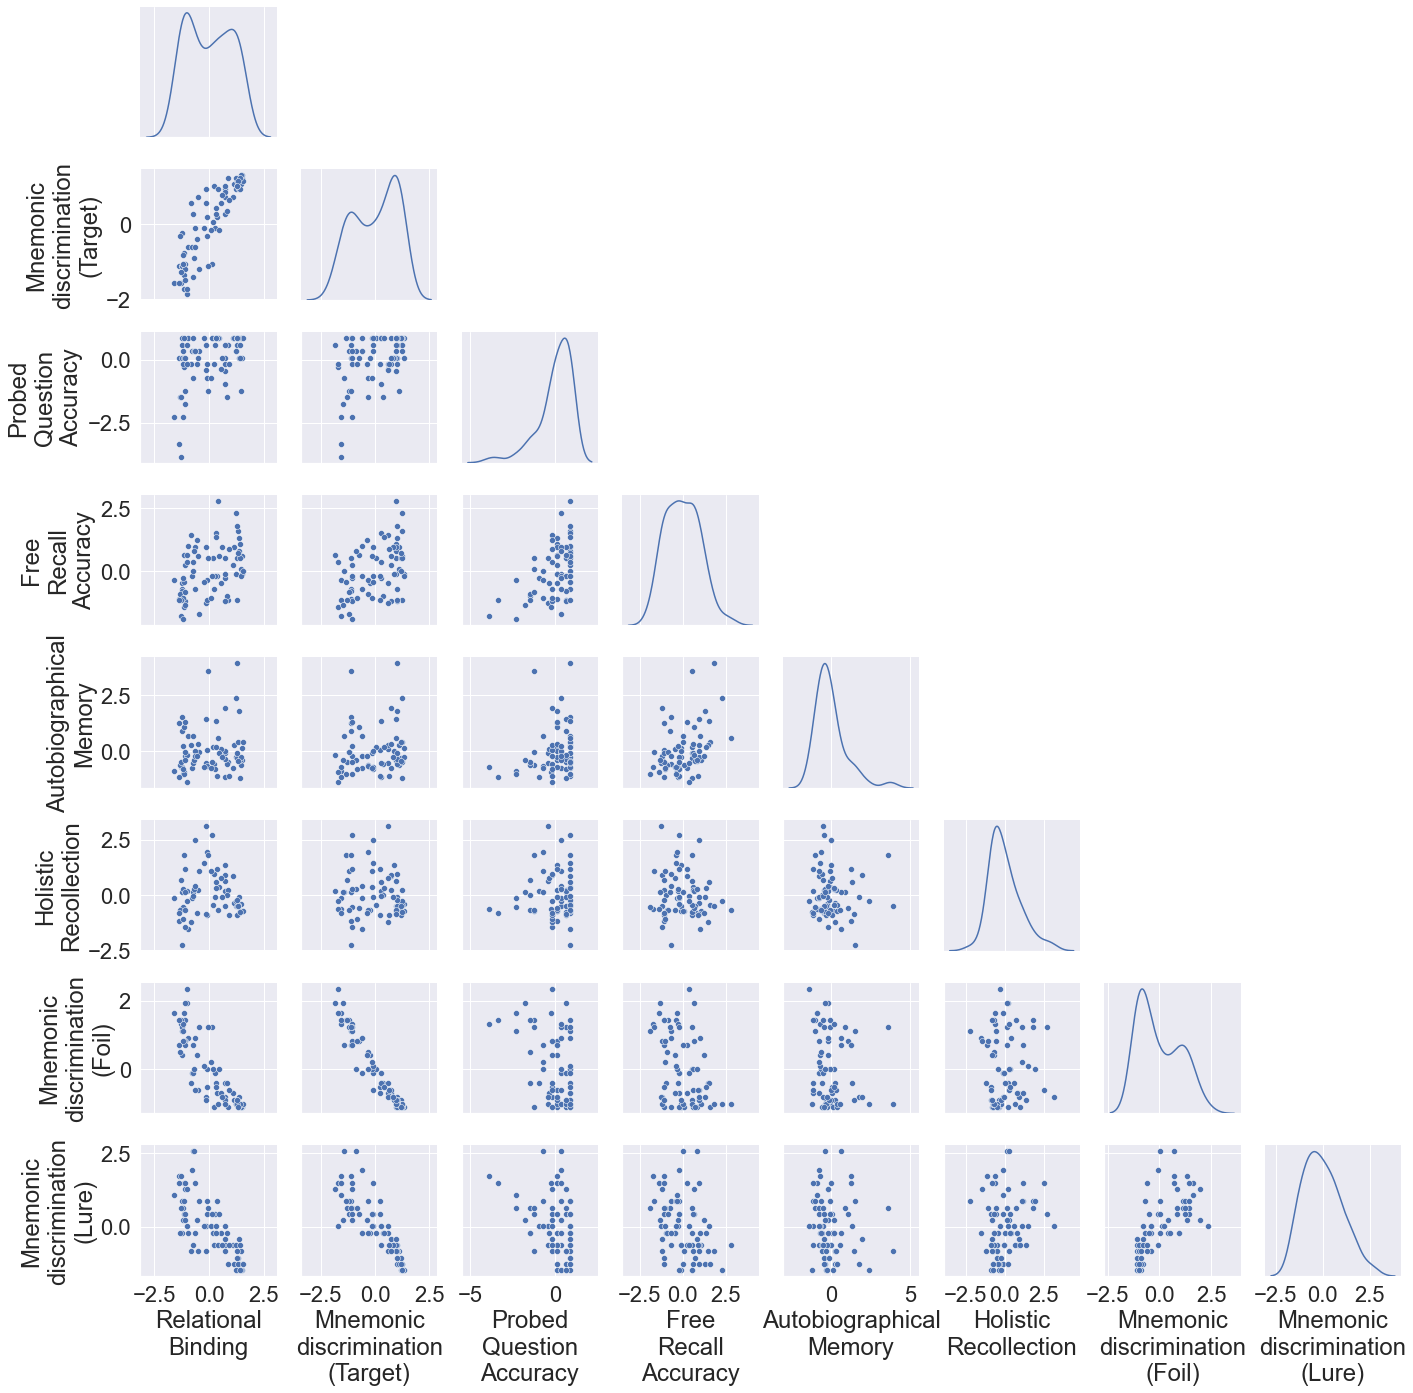

In [163]:
sns.set(font_scale=2)
g = sns.PairGrid(df_norm, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

In [164]:
# from:
# https://stackoverflow.com/questions/62303782/is-there-a-way-to-conduct-a-parallel-analysis-in-python
def _HornParallelAnalysis(data, K=100, printEigenvalues=False):
    ################
    # Create a random matrix to match the dataset
    ################
    n, m = data.shape
    # Set the factor analysis parameters
    fa = FactorAnalyzer(n_factors=1, method='minres', rotation=None, use_smc=True)
    # Create arrays to store the values
    sumComponentEigens = np.empty(m)
    sumFactorEigens = np.empty(m)
    # Run the fit 'K' times over a random matrix
    for runNum in range(0, K):
        fa.fit(np.random.normal(size=(n, m)))
        sumComponentEigens = sumComponentEigens + fa.get_eigenvalues()[0]
        sumFactorEigens = sumFactorEigens + fa.get_eigenvalues()[1]
    # Average over the number of runs
    avgComponentEigens = sumComponentEigens / K
    avgFactorEigens = sumFactorEigens / K

    ################
    # Get the eigenvalues for the fit on supplied data
    ################
    fa.fit(data)
    dataEv = fa.get_eigenvalues()
    # Set up a scree plot
    plt.figure(figsize=(8, 6))

    ################
    ### Print results
    ################
    if printEigenvalues:
        print('Principal component eigenvalues for random matrix:\n', avgComponentEigens)
        print('Factor eigenvalues for random matrix:\n', avgFactorEigens)
        print('Principal component eigenvalues for data:\n', dataEv[0])
        print('Factor eigenvalues for data:\n', dataEv[1])
    # Find the suggested stopping points
    suggestedFactors = sum((dataEv[1] - avgFactorEigens) > 0)
    suggestedComponents = sum((dataEv[0] - avgComponentEigens) > 0)
    print('Parallel analysis suggests that the number of factors = ', suggestedFactors , ' and the number of components = ', suggestedComponents)


    ################
    ### Plot the eigenvalues against the number of variables
    ################
    # Line for eigenvalue 1
    plt.plot([0, m+1], [1, 1], 'k--', alpha=0.3)
    # For the random data - Components
    plt.plot(range(1, m+1), avgComponentEigens, 'b', label='PC - random', alpha=0.4)
    # For the Data - Components
    plt.scatter(range(1, m+1), dataEv[0], c='b', marker='o')
    plt.plot(range(1, m+1), dataEv[0], 'b', label='PC - data')
    # For the random data - Factors
    plt.plot(range(1, m+1), avgFactorEigens, 'g', label='FA - random', alpha=0.4)
    # For the Data - Factors
    plt.scatter(range(1, m+1), dataEv[1], c='g', marker='o')
    plt.plot(range(1, m+1), dataEv[1], 'g', label='FA - data')
    plt.title('Parallel Analysis Scree Plots', {'fontsize': 20})
    plt.xlabel('Factors/Components', {'fontsize': 15})
    plt.xticks(ticks=range(1, m+1), labels=range(1, m+1))
    plt.ylabel('Eigenvalue', {'fontsize': 15})
    plt.legend()
    plt.show();

In [165]:
def EFA(df,n_factors):
    # inspired by: 
    # https://www.datacamp.com/tutorial/introduction-factor-analysis
    from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    print('Bartlett\'s test results:')
    print(chi_square_value, p_value)
    from factor_analyzer.factor_analyzer import calculate_kmo
    kmo_all,kmo_model=calculate_kmo(df)
    print('KMO test results:')
    print(kmo_model)
    # Create factor analysis object and perform factor analysis
    fa = FactorAnalyzer()
    fa.set_params(n_factors=3, rotation=None)
    fa.fit(df)
    # Check Eigenvalues
    ev, v = fa.get_eigenvalues()
    # Create scree plot using matplotlib
    plt.scatter(range(1,df.shape[1]+1),ev)
    plt.plot(range(1,df.shape[1]+1),ev)
    plt.title('Scree Plot')
    plt.xlabel('Factors')
    plt.ylabel('Eigenvalue')
    plt.grid()
    plt.show()
    # Create factor analysis object and perform factor analysis
    fa = FactorAnalyzer()
    fa.set_params(n_factors=n_factors, rotation="varimax")
    fa.fit(df)
    var_exp = fa.get_factor_variance()
    arr = np.concatenate((fa.loadings_, 
                          fa.get_factor_variance()[1][np.newaxis],), axis=0)
    factor_df=pd.DataFrame(arr,index=list(df.columns)+['Variance Explained'])
    print(factor_df)

Bartlett's test results:
nan nan
KMO test results:
0.7134127615972996


C:\Users\tuq67942\Anaconda3\lib\site-packages\factor_analyzer\factor_analyzer.py:109: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)
C:\Users\tuq67942\Anaconda3\lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


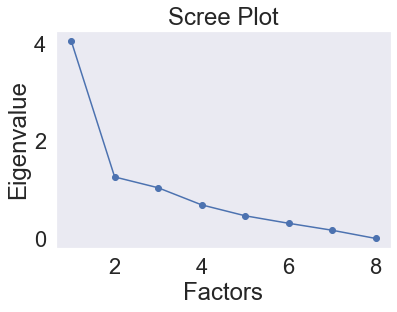

                                           0         1         2
Relational\nBinding                 0.881441  0.190121  0.039419
Mnemonic\ndiscrimination\n(Target)  0.989338  0.189394 -0.060583
Probed\nQuestion\nAccuracy          0.365968  0.454052  0.077235
Free\nRecall\nAccuracy              0.262421  0.848346 -0.092589
Autobiographical\nMemory            0.029847  0.448799 -0.026325
Holistic\nRecollection             -0.043395 -0.041432  0.736494
Mnemonic\ndiscrimination\n(Foil)   -0.904352 -0.203404 -0.037535
Mnemonic\ndiscrimination\n(Lure)   -0.786411 -0.171106  0.204999
Variance Explained                  0.424699  0.158957  0.075789
Parallel analysis suggests that the number of factors =  3  and the number of components =  1


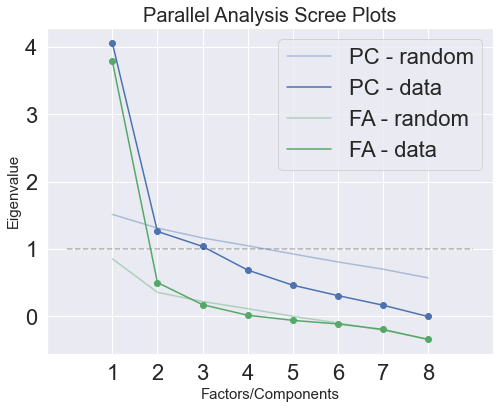

In [166]:
EFA(df_norm,3)
_HornParallelAnalysis(df_norm, K=100, printEigenvalues=False)

EFA w/o KBIT:
Bartlett's test results:
79.2264271651731 7.116855420426194e-13
KMO test results:
0.6716657369030437


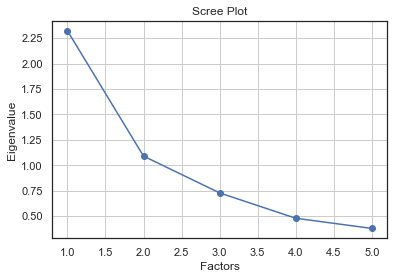

                           0         1
MausQs              0.332000  0.455551
MausFR              0.236945  0.865568
AM                  0.043630  0.439732
PCAccuracy          0.982301  0.176491
PSLocLure          -0.568999 -0.154599
Variance Explained  0.291389  0.241030
Parallel analysis suggests that the number of factors =  2  and the number of components =  1


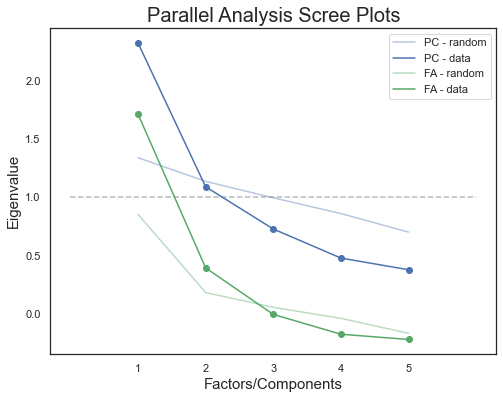

In [49]:
df_nokbit = df_norm.drop(['KBit_Score','Raw KBIT'], axis=1)
print('EFA w/o KBIT:')
EFA(df_nokbit,2)
_HornParallelAnalysis(df_nokbit, K=100, printEigenvalues=False)

In [20]:
# from:
# https://stackoverflow.com/questions/54347275/confirmatory-factor-analysis-in-python
from factor_analyzer import (ConfirmatoryFactorAnalyzer, ModelSpecificationParser)    
model_dict = {"F1": ['PCAccuracy','PSLocLure'], "F2": ['MausQs', 'MausFR','AM']}
model_spec = ModelSpecificationParser.parse_model_specification_from_dict(df_nokbit, model_dict)
cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=True) 
cfa.fit(df_nokbit.values) 
cfa.loadings_ 

array([[ 1.14445425,  0.        ],
       [ 0.98356122,  0.        ],
       [ 0.        , -1.56843807],
       [ 0.        ,  4.93987078],
       [ 0.        , -2.61116823]])